# Combine CMIP6 and LongRunMIP figures

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import random as rd
from lmfit import Model
from lmfit.model import save_modelresult, load_modelresult
from scipy import optimize
import importlib
import xarray as xr
from data_loading_functions import *

plt.rcParams.update({'figure.max_open_warning': 0})

## CMIP6 models

In [2]:
exp = 'abrupt-4xCO2'

model_anom_names = [ f.name for f in os.scandir('../../Processed_data/Global_annual_anomalies/') if f.is_dir() and f.name !='.ipynb_checkpoints']
model_anom_names.sort()

member_dict = {}
for model in model_anom_names:
    anom_exp = [ f.name for f in os.scandir('../../Processed_data/Global_annual_anomalies/' + model) if f.is_dir() and f.name !='.ipynb_checkpoints']
    if exp in anom_exp:
        member_dict[model] = find_members(model, exp)
member_dict

{'ACCESS-CM2': ['r1i1p1f1'],
 'ACCESS-ESM1-5': ['r1i1p1f1', 'r2i1p1f1'],
 'AWI-CM-1-1-MR': ['r1i1p1f1'],
 'BCC-CSM2-MR': ['r1i1p1f1'],
 'BCC-ESM1': ['r1i1p1f1'],
 'CAMS-CSM1-0': ['r1i1p1f1', 'r2i1p1f1'],
 'CAS-ESM2-0': ['r1i1p1f1'],
 'CESM2': ['r1i1p1f1'],
 'CESM2-FV2': ['r1i1p1f1'],
 'CESM2-WACCM': ['r1i1p1f1'],
 'CESM2-WACCM-FV2': ['r1i1p1f1'],
 'CIESM': ['r1i1p1f1'],
 'CMCC-CM2-SR5': ['r1i1p1f1'],
 'CMCC-ESM2': ['r1i1p1f1'],
 'CNRM-CM6-1': ['r1i1p1f2',
  'r2i1p1f2',
  'r3i1p1f2',
  'r4i1p1f2',
  'r5i1p1f2',
  'r6i1p1f2'],
 'CNRM-CM6-1-HR': ['r1i1p1f2'],
 'CNRM-ESM2-1': ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2'],
 'CanESM5': ['r1i1p1f1', 'r1i1p2f1'],
 'E3SM-1-0': ['r1i1p1f1'],
 'EC-Earth3': ['r3i1p1f1', 'r8i1p1f1'],
 'EC-Earth3-AerChem': ['r1i1p1f1'],
 'EC-Earth3-CC': ['r1i1p1f1'],
 'EC-Earth3-Veg': ['r1i1p1f1'],
 'FGOALS-f3-L': ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1'],
 'FGOALS-g3': ['r1i1p1f1'],
 'GFDL-CM4': ['r1i1p1f1'],
 'GFDL-ESM4': ['r1i1p1f1'],
 'GISS-E2-1-G': ['r102i1p1f1', 'r1i1p1f1',

In [3]:
# Define functions:


def exp_part1(t, S1, tau1):
    return S1*(1 - np.exp(-t/tau1))
def exp_part2(t, S2, tau2):
    return S2*(1 - np.exp(-t/tau2))
def exp_part3(t, S3, tau3):
    return S3*(1 - np.exp(-t/tau3))
def osc_parts(t, Sosc1, Sosc2, taup, Tq):
    p = -1/taup; q = 2*np.pi/Tq
    osc_part1 = Sosc1*(1 - np.exp(-t/taup)*(np.cos(q*t) + p/q*np.sin(q*t)))
    osc_part2 = Sosc2*(1 - np.exp(-t/taup)*(np.cos(q*t) - q/p*np.sin(q*t)))
    return osc_part1 + osc_part2

def twoexp_function(t, S1, S2, tau1, tau2):
    return exp_part1(t, S1, tau1) + exp_part2(t, S2, tau2)
def threeexp_function(t, S1, S2, S3, tau1, tau2, tau3):
    return exp_part1(t, S1, tau1) + exp_part2(t, S2, tau2) + exp_part3(t, S3, tau3)
def expandosc_function(t, S1, S2, Sosc1, Sosc2, tau1, tau2, taup, Tq):
    return exp_part1(t, S1, tau1) + exp_part2(t, S2, tau2) + osc_parts(t, Sosc1, Sosc2, taup, Tq)

exp_model1 = Model(exp_part1); exp_model2 = Model(exp_part2); 
twoexp_model = Model(twoexp_function);
twoexp_model.set_param_hint('S1', value=4, min=0, max=10.0)
twoexp_model.set_param_hint('S2', value=2, min=0, max=10.0)
twoexp_model.set_param_hint('tau1', value=4, min=0, max=8)
twoexp_model.set_param_hint('tau2', value=20, min=8, max=1000)

exp_model3 = Model(exp_part3); threeexp_model = Model(threeexp_function);
threeexp_model.set_param_hint('S1', value=4, min=0, max=10.0)
threeexp_model.set_param_hint('S2', value=2, min=0, max=10.0)
threeexp_model.set_param_hint('S3', value=2, min=0, max=10.0)
threeexp_model.set_param_hint('tau1', value=4, min=0, max=8)
threeexp_model.set_param_hint('tau2', value=20, min=8, max=100)
threeexp_model.set_param_hint('tau3', value=200, min=100, max=1000)

osc_model = Model(osc_parts); expandosc_model = Model(expandosc_function)
expandosc_model.set_param_hint('S1', value=4, min=0, max=10.0)# guess the same as for two-box model 
expandosc_model.set_param_hint('S2', value=2, min=0, max=10.0)
expandosc_model.set_param_hint('Sosc1', value=0.5, min=0, max=4.0)
expandosc_model.set_param_hint('Sosc2', value=0.5, min=0, max=4.0)
expandosc_model.set_param_hint('tau1', value=4, min=0, max=8)
expandosc_model.set_param_hint('tau2', value=20, min=8, max=1000)


expandosc_model.set_param_hint('taup', value=600, min=20, max=1000)
#expandosc_model.set_param_hint('Tq', value=400, min=40, max=2000) # used for longrunmip
expandosc_model.set_param_hint('Tq', value=100, min=40, max=2000)

def modelresult_figure(response_model, model_result, years0, deltaT0, axis = None):
    # takes in response models: 'twoexp', 'threeexp', 'expandosc'
    if axis == None:
        #then create new axis:
        fig, axis = plt.subplots(figsize = [8,6])
        
    axis.set_xlabel('Year',fontsize = 18)
    axis.set_ylabel('T [K]',fontsize = 18)
    axis.set_xlim(min(years0),max(years0))
    axis.tick_params(axis='both',labelsize=18)
    axis.plot(years0, deltaT0, color = 'black')
    
    residuals = model_result.best_fit - model_result.data
    model_rmse = np.sqrt(np.mean(residuals**2))
    #model_rmse = np.sqrt(np.mean(model_result.residual**2))
    axis.plot(years0, model_result.best_fit, '-', label='best fit', color = 'blue', linewidth = 2)
    
    # plot components
    axis.plot(years0, exp_model1.eval(model_result.params, t=years0), color = 'lightblue')
    axis.plot(years0, exp_model2.eval(model_result.params, t=years0), color = 'lightblue')
    if response_model == 'twoexp':
        axis.set_title('Two-exponential fit', fontsize = 18)
        partoshow = ['S1', 'S2', 'tau1', 'tau2']
        textlabels = ['$S_1$', '$S_2$', r'$\tau_1$', r'$\tau_2$']
    elif response_model == 'threeexp':
        axis.plot(years0, exp_model3.eval(model_result.params, t=years0), color = 'lightblue')
        axis.set_title('Three-exponential fit', fontsize = 18)
        partoshow = ['S1', 'S2', 'S3', 'tau1', 'tau2', 'tau3']
        textlabels = ['$S_1$', '$S_2$', '$S_3$', r'$\tau_1$', r'$\tau_2$', r'$\tau_3$']
    elif response_model == 'expandosc':
        axis.plot(years0, osc_model.eval(model_result.params, t=years0), color = 'lightblue')
        axis.set_title('Two-exponential and oscillatory fit', fontsize = 18)
        partoshow = ['S1', 'S2', 'Sosc1', 'Sosc2', 'tau1', 'tau2', 'taup', 'Tq']
        textlabels = ['$S_1$', '$S_2$', '$S_{osc1}$', '$S_{osc2}$', r'$\tau_1$', r'$\tau_2$', r'$\tau_p$', r'$T_q$']
        
    estimates = [model_result.best_values[par] for par in partoshow]
    axis.text(0.01, 0.95, 'RMSE = ' + str(np.round(model_rmse,3)), transform=axis.transAxes, fontsize = 16)
    axis.text(0.75,0.55, 'Estimates:', fontsize=14, transform=axis.transAxes)
    for (ind, estimate) in enumerate(estimates):
        axis.text(0.75,0.5*(1-ind/8),textlabels[ind] + ' = ' + str('{:.2f}'.format(np.round(estimate,2))), fontsize=14, transform=axis.transAxes)
    return axis
    


def plot_3fits(years0, deltaT0, model, exp, member, load_results = False, save_results = False, save_figure = False):
    fig, ax = plt.subplots(ncols = 3, figsize = [25,6]);
    fig.suptitle(model + ' ' + member + ' responses to ' + exp, fontsize = 22)
    response_models = ['twoexp', 'threeexp', 'expandosc']
    response_functions = [twoexp_function, threeexp_function, expandosc_function]
    
    rmse_values = []
    for (ax_index, axis) in enumerate(ax):
        response_model = response_models[ax_index]; response_function = response_functions[ax_index]
        
        result_file = '../model_results/' + model + '_' + exp + '_' + member + '_' + response_model + '_results.sav'
        if load_results == True:
            model_result = load_modelresult(result_file, funcdefs = {response_model + '_function': response_function})
            #model_rmse = np.sqrt(np.mean(model_result.residual**2))
            # attribute residual seems to be missing
            # but we can compute it manually from other attributes:
            residuals = model_result.best_fit - model_result.data
            model_rmse = np.sqrt(np.mean(residuals**2))
        else: # obtain new results
            if response_model == 'twoexp':
                model_to_fit = twoexp_model
            elif response_model == 'threeexp':
                model_to_fit = threeexp_model
            elif response_model == 'expandosc':
                model_to_fit = expandosc_model
                 
            model_result = model_to_fit.fit(deltaT0, t=years0)
            model_rmse = np.sqrt(np.mean(model_result.residual**2))
            if response_model == 'expandosc':
                twoexp_rmse = rmse_values[0]
                #if model_rmse > twoexp_rmse: 
                i=0;
                #while model_rmse > twoexp_rmse: # if worse than twoexp, then make new fit
                #    print(i, model, exp)
                #    taup_guess = 10**rd.uniform(np.log10(20), np.log10(1000))
                #    Tq_guess = 10**rd.uniform(np.log10(40), np.log10(2000))
                #    expandosc_model.set_param_hint('taup', value=taup_guess, min=20, max=1000)
                #    expandosc_model.set_param_hint('Tq', value=Tq_guess, min=40, max=2000)
                #    model_result = expandosc_model.fit(deltaT0, t=years0)
                #    model_rmse = np.sqrt(np.mean(model_result.residual**2))
                #    i += 1; 
                # reset par hints:
                #expandosc_model.set_param_hint('taup', value=600, min=20, max=1000)
                #expandosc_model.set_param_hint('Tq', value=100, min=40, max=2000)
        if save_results == True:
             save_modelresult(model_result, result_file) 
        
        modelresult_figure(response_model, model_result, years0, deltaT0, axis = axis)
        rmse_values.append(model_rmse)
    if save_figure == True:
        plt.savefig('../Figures/CMIP6_modelcomparisons/' + model + '_' + member + '_' + exp + '_linresponses_comparison.pdf', format='pdf', dpi=600, bbox_inches="tight")
    
    return rmse_values
        



ACCESS-CM2


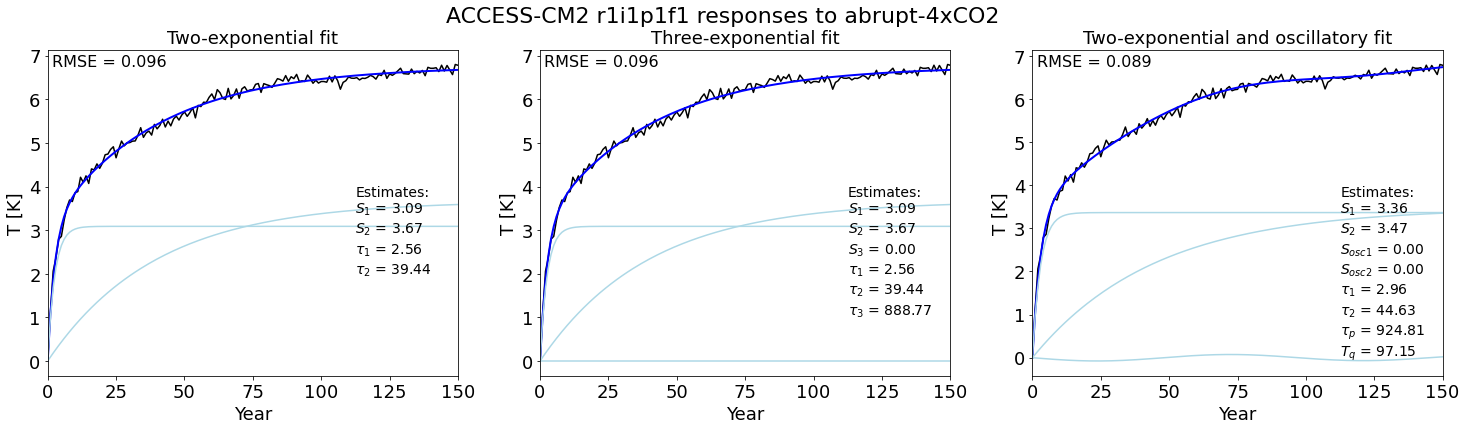

GISS-E2-1-G


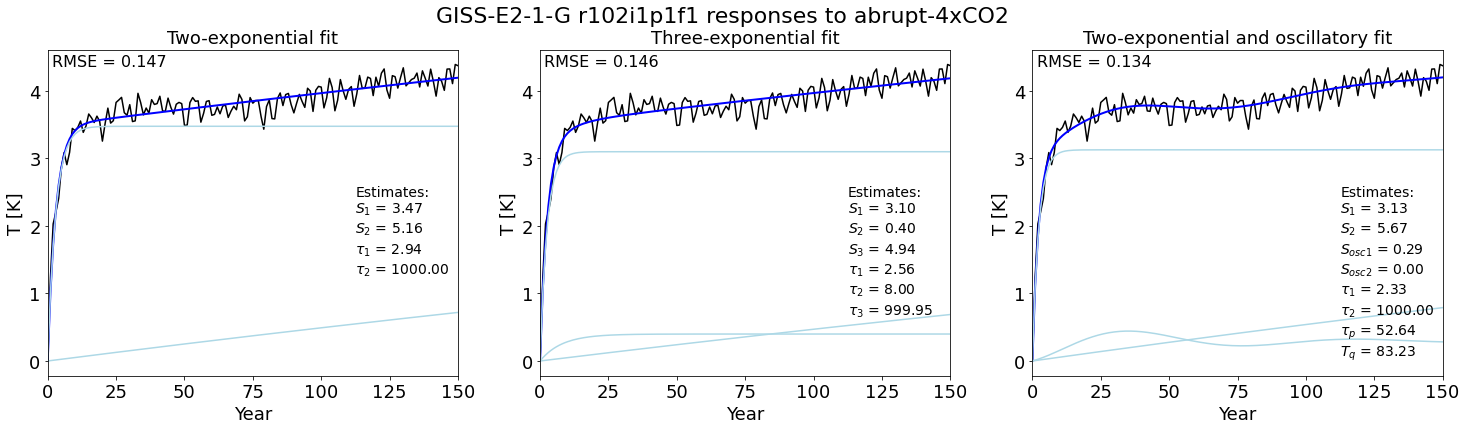

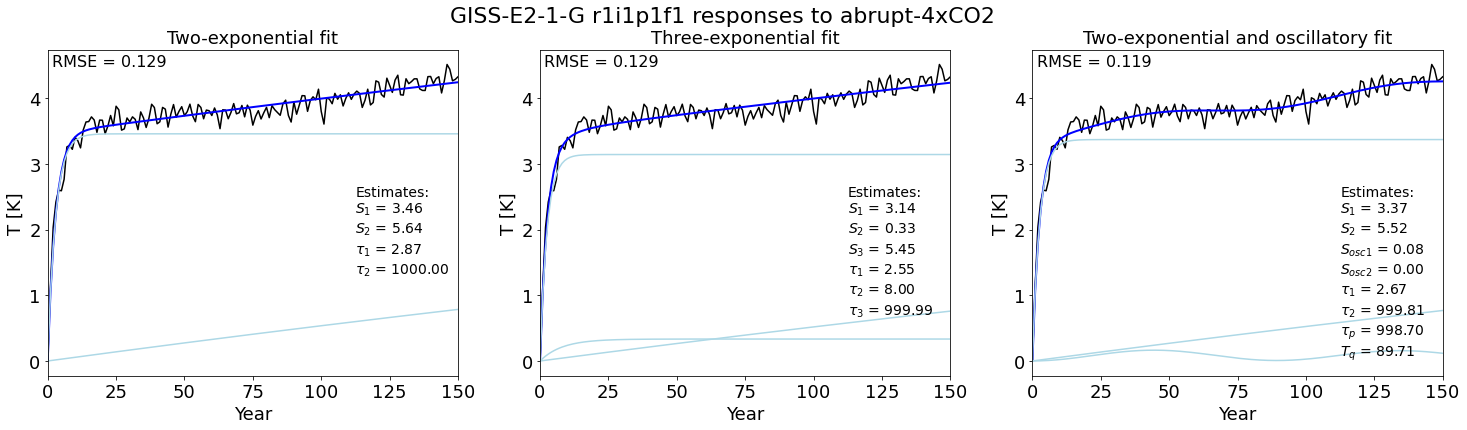

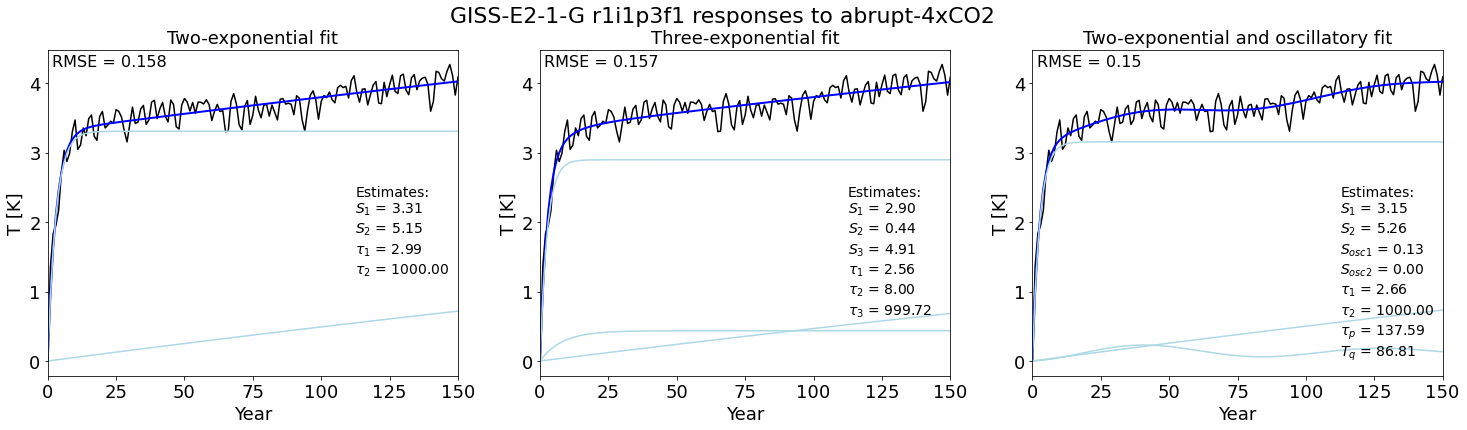

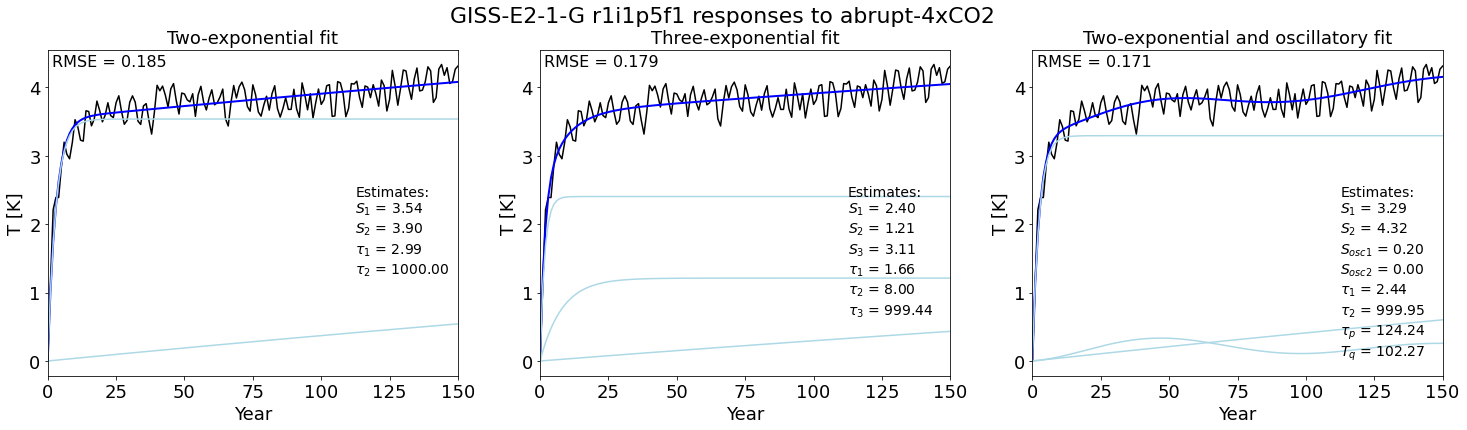

ICON-ESM-LR


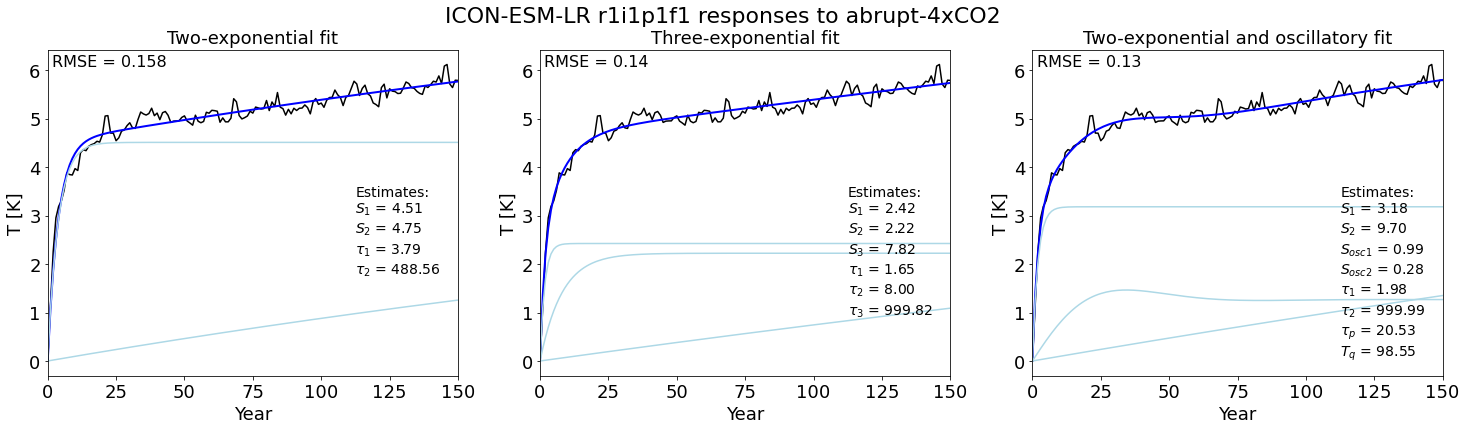

KIOST-ESM


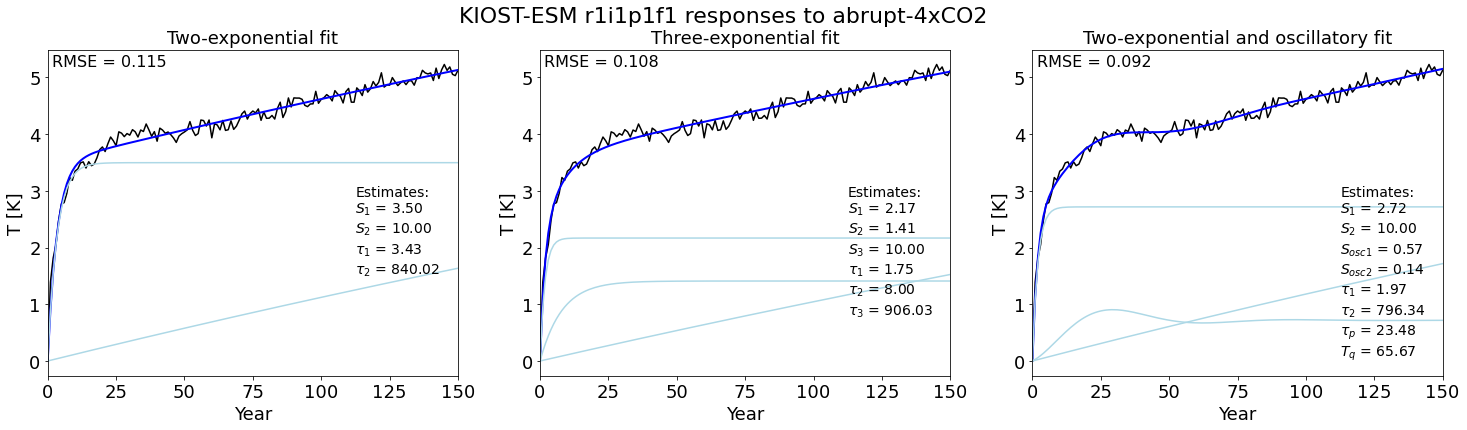

MRI-ESM2-0


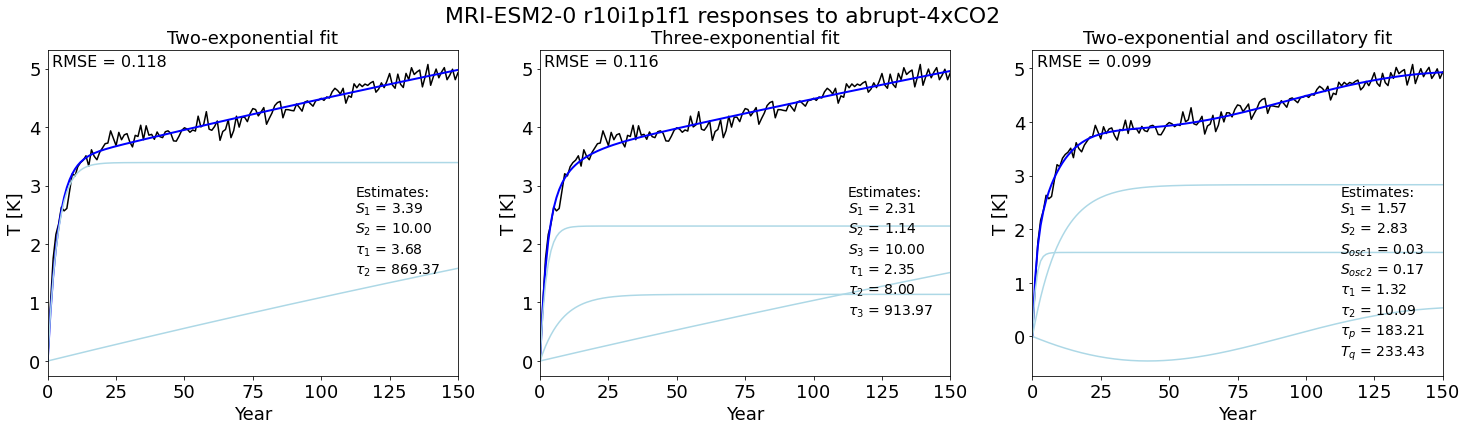

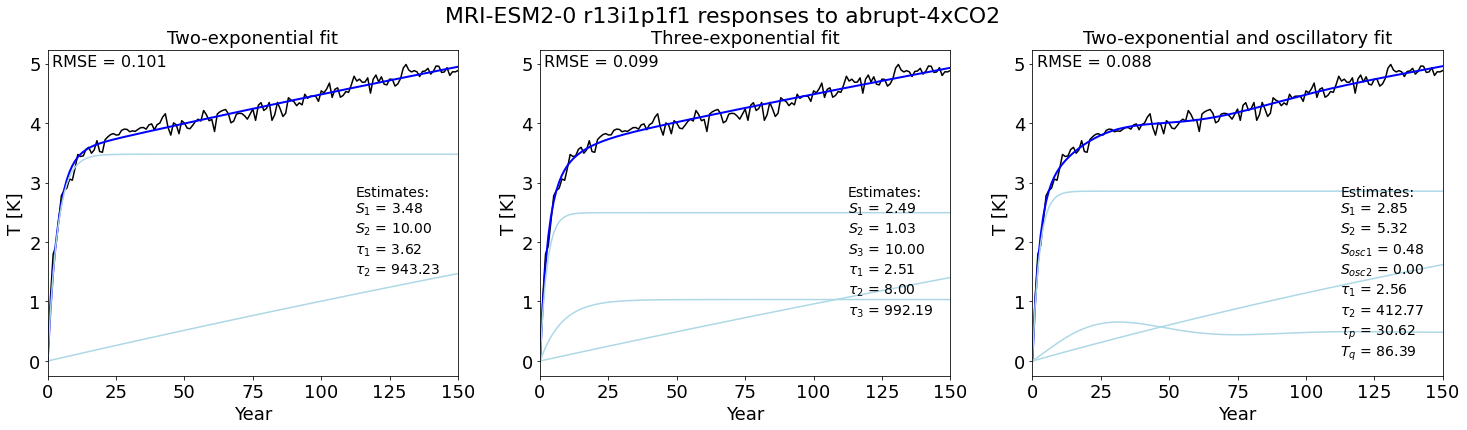

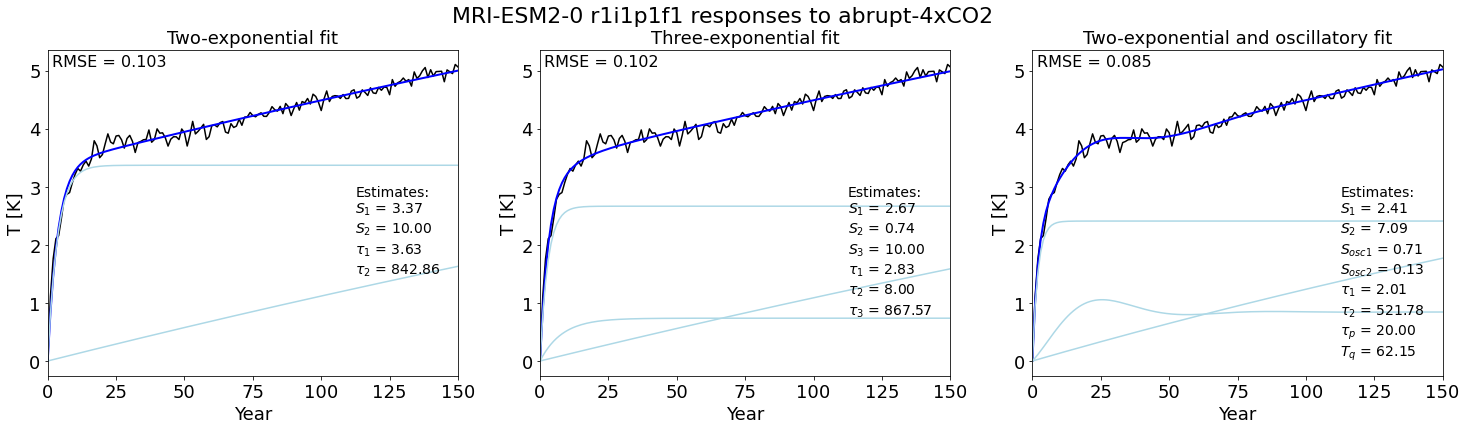

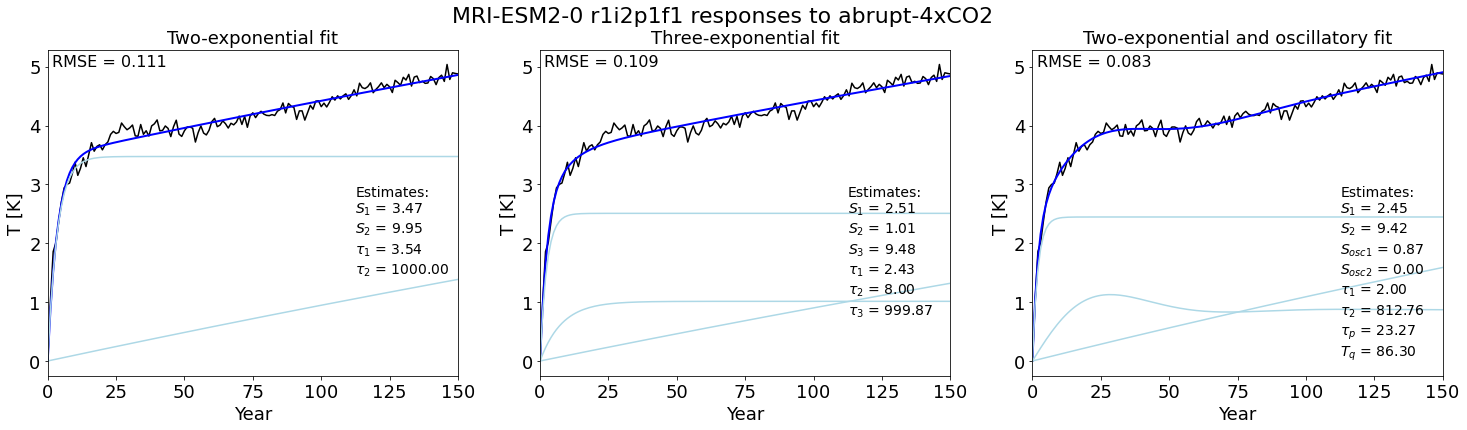

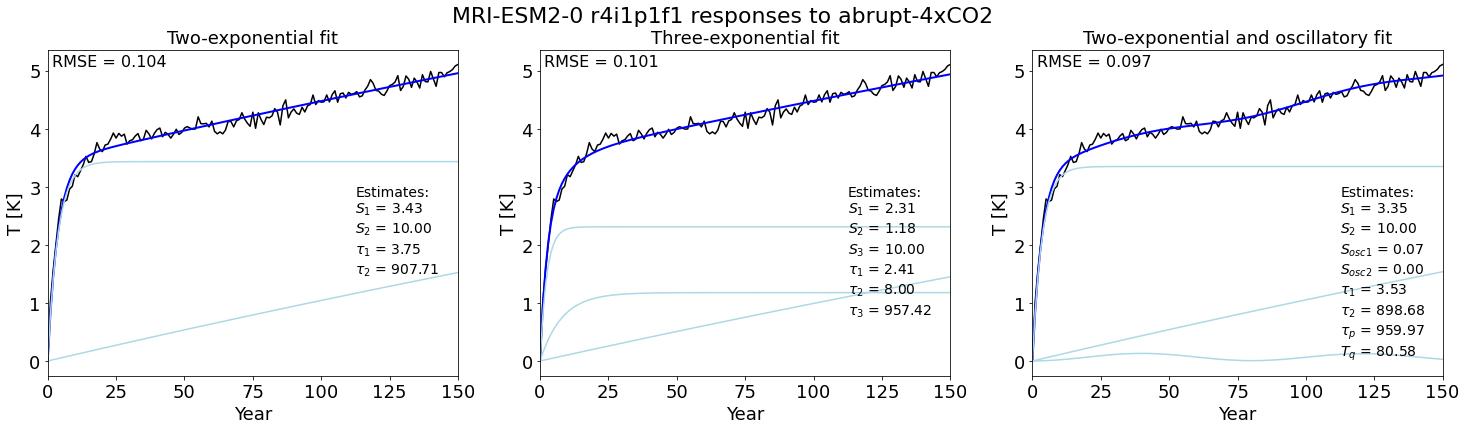

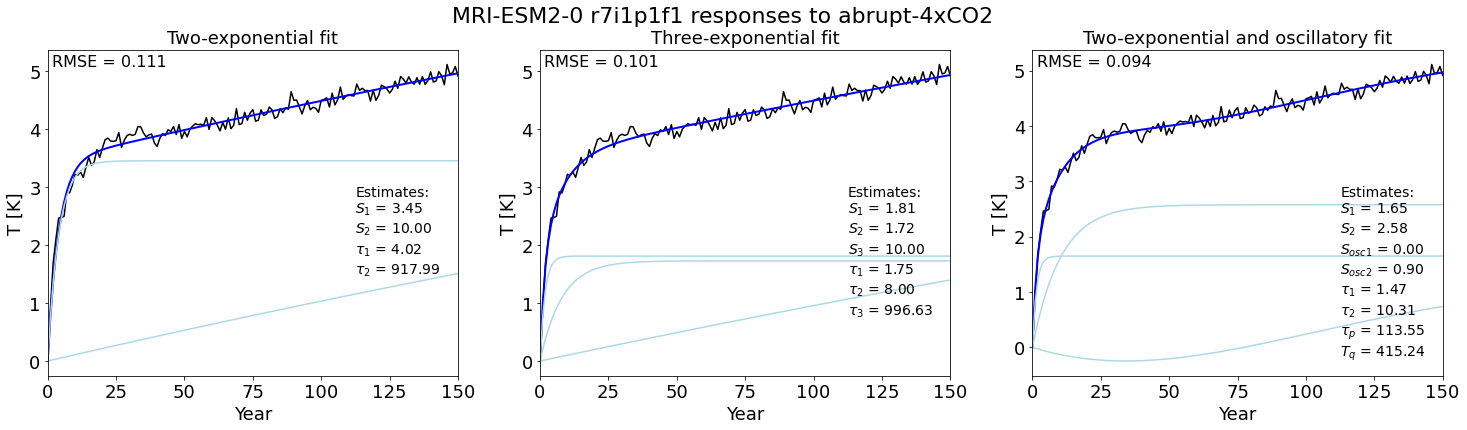

NorESM2-LM


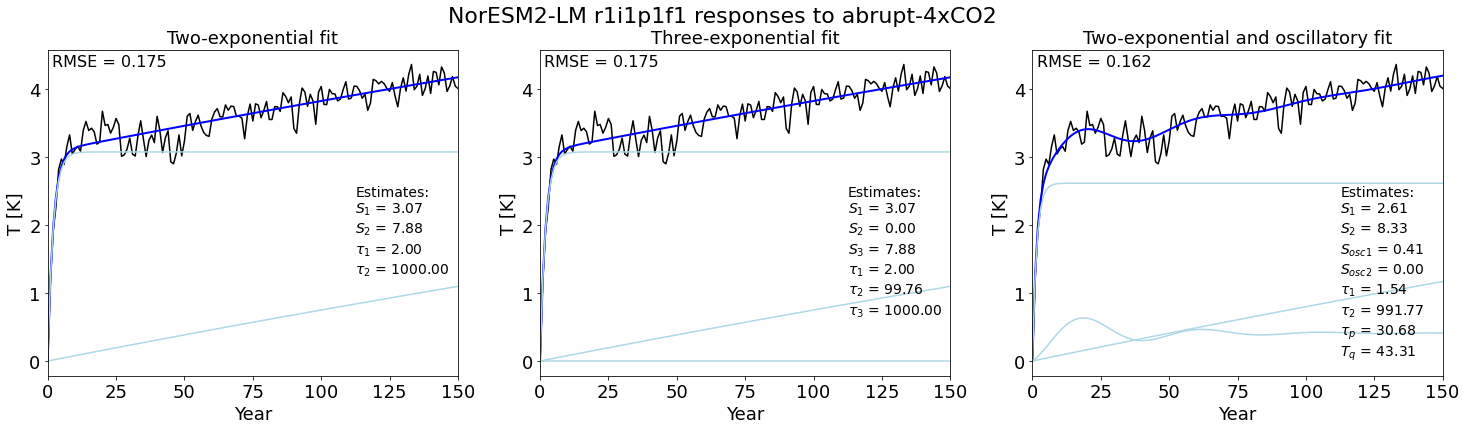

SAM0-UNICON


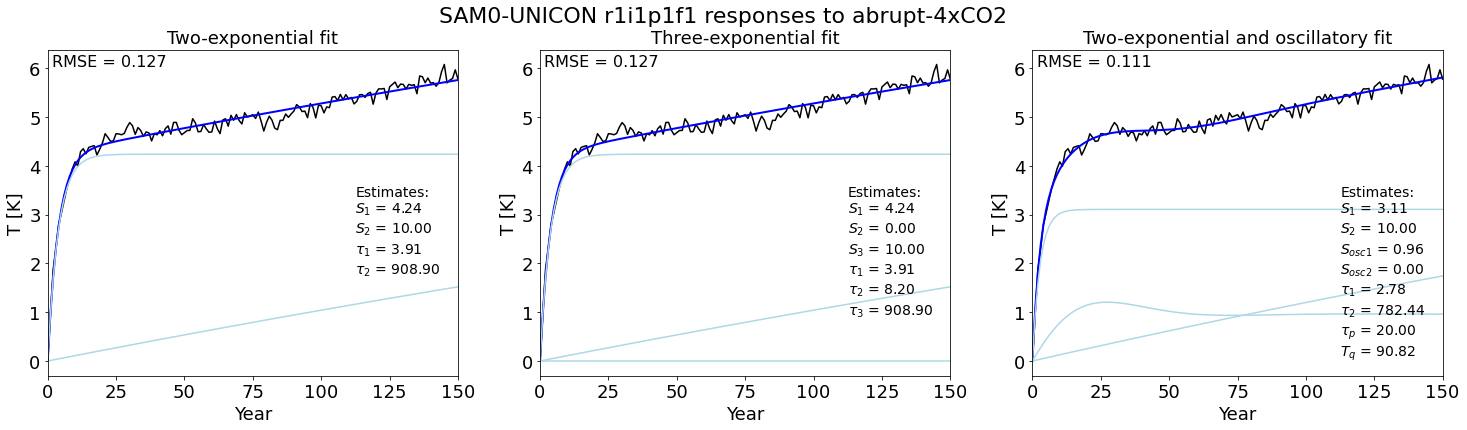

TaiESM1


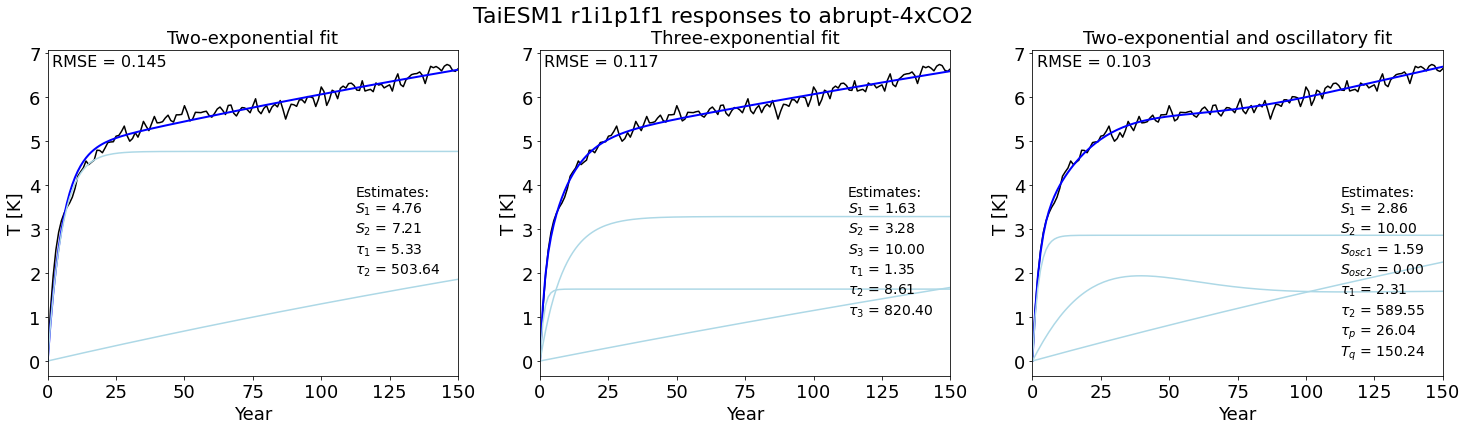

{'ACCESS-CM2': {'r1i1p1f1': [0.0958135114071507,
   0.09581351140875066,
   0.0888563639562056]},
 'GISS-E2-1-G': {'r102i1p1f1': [0.14682115593256184,
   0.14641795505566363,
   0.1340832219572265],
  'r1i1p1f1': [0.12890692588892344, 0.12859923101646428, 0.11852247614658758],
  'r1i1p3f1': [0.15775664874761447, 0.1572735308750472, 0.14974735580015086],
  'r1i1p5f1': [0.18525156547132937, 0.1793249978528965, 0.1713173149234677]},
 'ICON-ESM-LR': {'r1i1p1f1': [0.15808246462654163,
   0.13974390360019157,
   0.12997370197618008]},
 'KIOST-ESM': {'r1i1p1f1': [0.11531013946745255,
   0.1075360497026299,
   0.09153877645913493]},
 'MRI-ESM2-0': {'r10i1p1f1': [0.11766124468313824,
   0.11556625187513646,
   0.09864259044782797],
  'r13i1p1f1': [0.10148320262356997, 0.09864161640748136, 0.08793727741545244],
  'r1i1p1f1': [0.10265036106905566, 0.10202049375811037, 0.0852173750356365],
  'r1i2p1f1': [0.11146831934045935, 0.10899115901010713, 0.08314013968123929],
  'r4i1p1f1': [0.1041989925171

In [4]:
# Compute rmse_dict
rmse_list = []; rmse_dict = {}

for model in ['ACCESS-CM2', 'GISS-E2-1-G', 'ICON-ESM-LR', 'KIOST-ESM', 'MRI-ESM2-0', 'NorESM2-LM', 'SAM0-UNICON', 'TaiESM1']:
#for model in member_dict:
    rmse_dict[model] = {}
    print(model)
    for member in member_dict[model]:
        data = load_anom(model, exp, member, length_restriction = 150)
        deltaN = data['rsdt'] - data['rsut'] - data['rlut']
        deltaT = data['tas']; years = np.arange(1,150+1)
        if len(deltaT)<150:
            continue
        deltaT0 = np.concatenate(([0],deltaT)); years0 = np.concatenate(([0],years))

        #plot_3fits(years0, deltaT0, model, exp, member)
        #rmse_values = plot_3fits(years0, deltaT0, model, exp, member, load_results = False, save_results = True)
        rmse_values = plot_3fits(years0, deltaT0, model, exp, member, load_results = True, save_figure = False)
        rmse_dict[model][member] = rmse_values
        rmse_values = [model, exp, member] + rmse_values
        rmse_list.append(rmse_values)
        plt.show()
        
rmse_dict


ACCESS-CM2
GISS-E2-1-G
ICON-ESM-LR
KIOST-ESM
MRI-ESM2-0
NorESM2-LM
SAM0-UNICON
TaiESM1


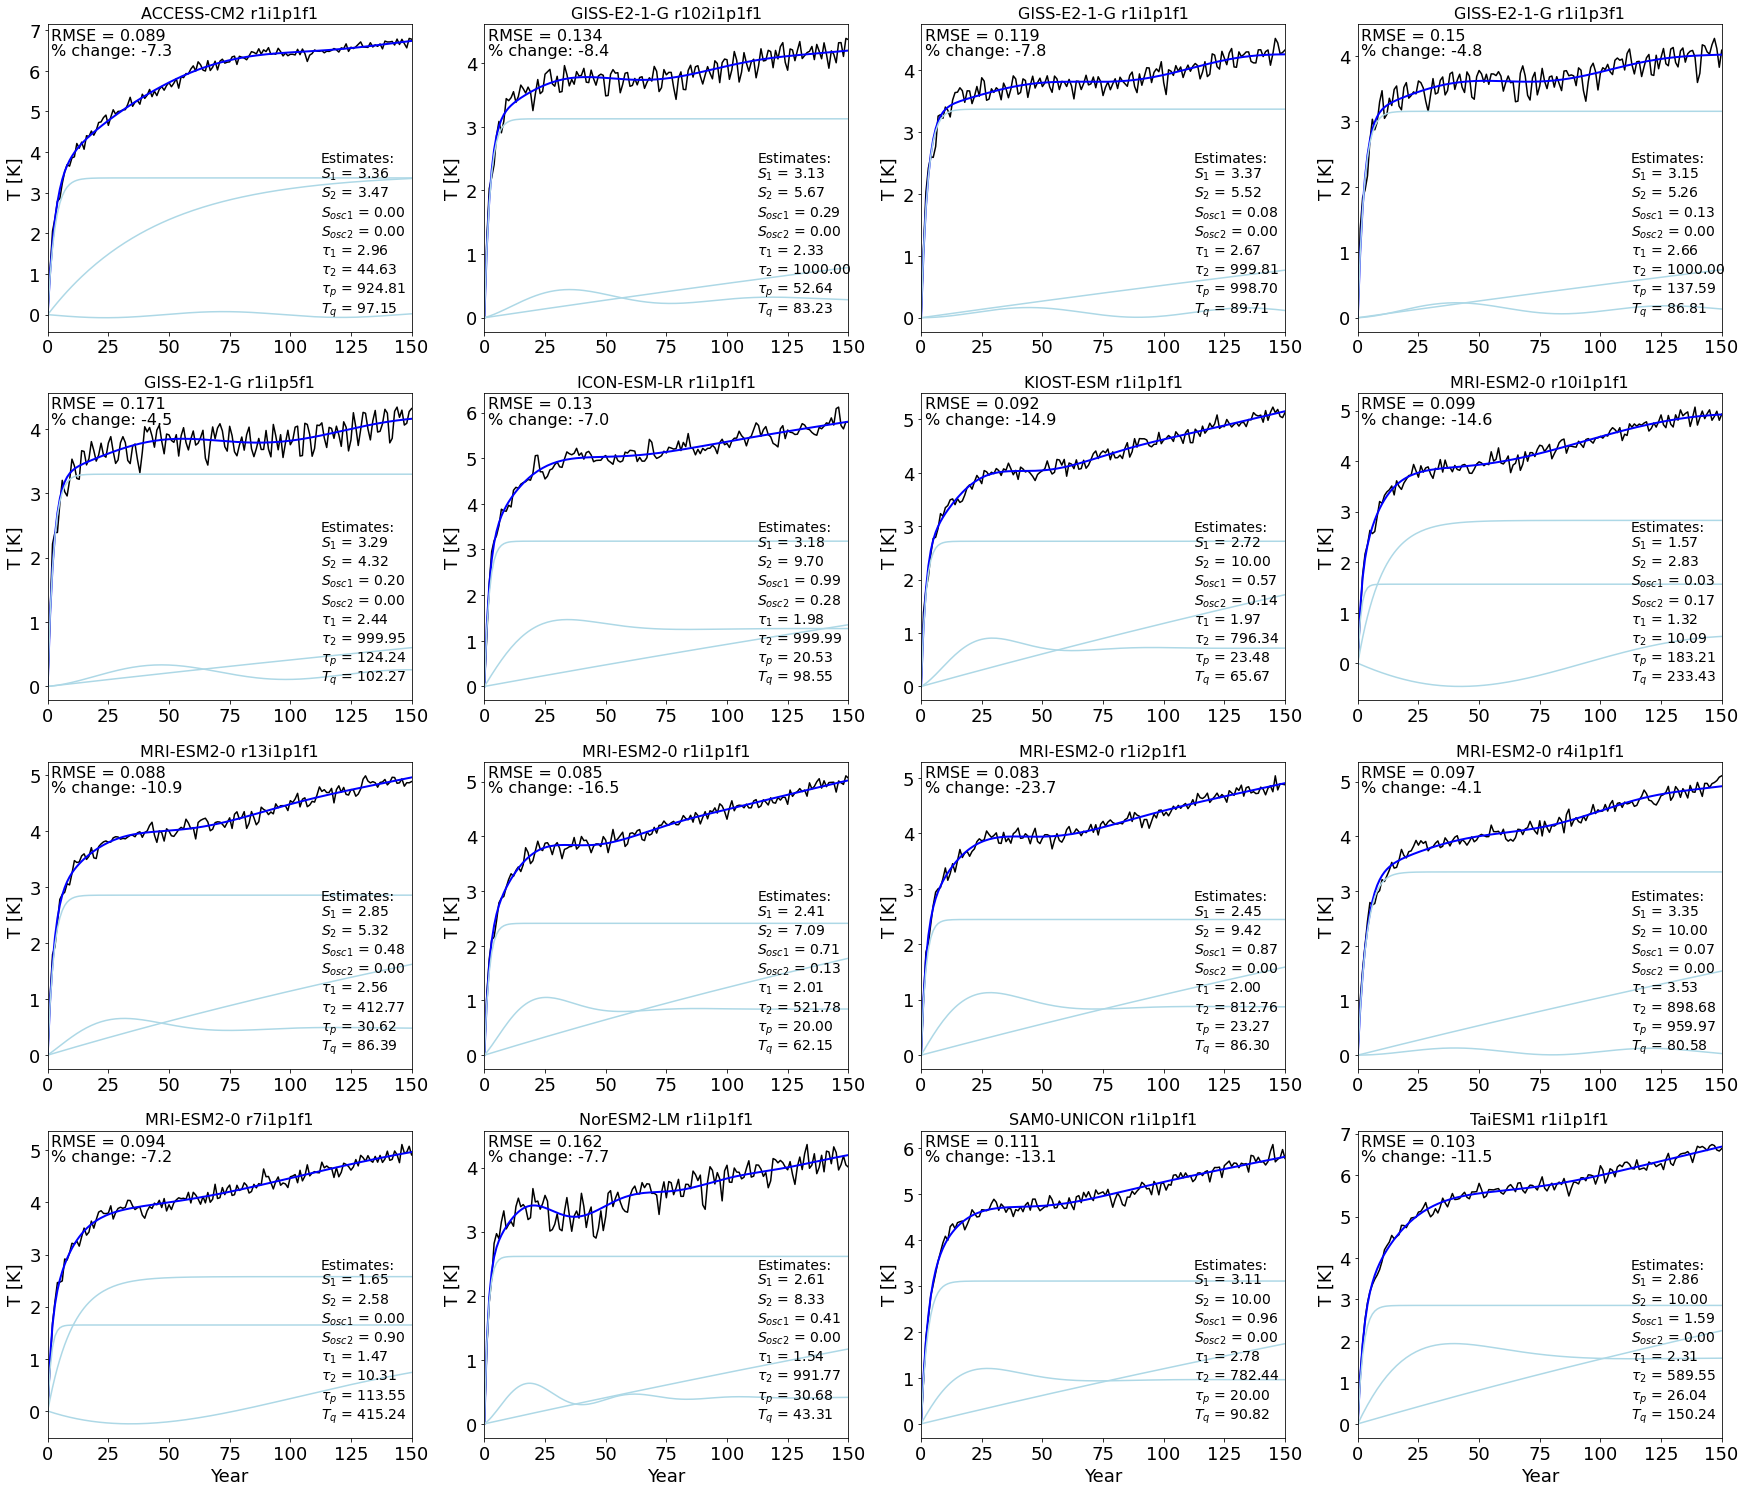

In [5]:
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = [30,26])
ax = np.concatenate(axes)
k = 0 # axis index
for model in ['ACCESS-CM2', 'GISS-E2-1-G', 'ICON-ESM-LR', 'KIOST-ESM', 'MRI-ESM2-0', 'NorESM2-LM', 'SAM0-UNICON', 'TaiESM1']:
#for model in member_dict:
    print(model)
    for member in member_dict[model]:
        data = load_anom(model, exp, member, length_restriction = 150)
        deltaN = data['rsdt'] - data['rsut'] - data['rlut']
        deltaT = data['tas']; years = np.arange(1,150+1)
        if len(deltaT)<150:
            continue
        deltaT0 = np.concatenate(([0],deltaT)); years0 = np.concatenate(([0],years))
        result_file = '../model_results/' + model + '_' + exp + '_' + member + '_expandosc_results.sav'
        model_result = load_modelresult(result_file, funcdefs = {'expandosc_function': expandosc_function})
        ax[k] = modelresult_figure('expandosc', model_result, years0, deltaT0, axis = ax[k])
        ax[k].set_title(model + ' ' + member, fontsize = 16)
        #ax[k].set_title(model + ' ' + exp + ' ' + member, fontsize = 16)
        rmse_change = 100*(rmse_dict[model][member][2] - rmse_dict[model][member][1])/rmse_dict[model][member][1]
        ax[k].text(0.01, 0.9, '% change: ' + str(np.round(rmse_change,1)), transform=ax[k].transAxes, fontsize = 16)
        if k<12:
            ax[k].set_xlabel('')
        k += 1
        
#plt.savefig('../Figures/' + exp + '_16expandosc_results.pdf', format='pdf', dpi=600, bbox_inches="tight")        
#plt.savefig('../Figures/' + exp + '_16expandosc_results.png', format='png', dpi=600, bbox_inches="tight")        


## LongRunMIP models

In [22]:
def find_longrunmip_files(model, exp):
    directory = '../../longrunmip_data/'
    file_str = model + '_' + exp
    filenames = [f.name for f in os.scandir(directory) if file_str in f.name]
    filenames.sort()
    tas_file = filenames[1]; nettoa_file = filenames[0]
    return [tas_file, nettoa_file]

def get_tas(model, exp, add_0 = True, remove_nan = False, return_years = False):
    directory = '../../longrunmip_data/'
    [tas_file, nettoa_file] = find_longrunmip_files(model, exp)
    ds_tas = xr.open_dataset(directory + tas_file)
    deltaT = ds_tas.tas.values
    if remove_nan == True:
        deltaT = deltaT[np.isnan(deltaT)==False]
    years = np.arange(1,len(deltaT)+1)
    if add_0 == True:
        deltaT = np.concatenate([[0],deltaT])
        years = np.concatenate(([0],years))
        
    if return_years == True:
        return [years, deltaT]
    else:
        return deltaT
    
def modelresult_figure_longrunmip(response_model, model_result, years0, deltaT0, axis = None, length_restriction = None):
    # takes in response models: 'twoexp', 'threeexp', 'expandosc'
    if axis == None:
        #then create new axis:
        fig, axis = plt.subplots(figsize = [8,6])
        
    axis.set_xlabel('Year',fontsize = 18)
    axis.set_ylabel('T [K]',fontsize = 18)
    axis.tick_params(axis='both',labelsize=18)
    axis.plot(years0, deltaT0, color = 'black')
    
    if length_restriction == None:
        model_best_fit = model_result.best_fit
        model_data = model_result.data
    else: # shorten all data. +1 because year 0 is included
        model_best_fit = model_result.best_fit[:length_restriction+1]
        model_data = model_result.data[:length_restriction+1]
        years0 = years0[:length_restriction+1]
     
    axis.set_xlim(min(years0),max(years0))
    residuals = model_best_fit - model_data
    
    model_rmse = np.sqrt(np.mean(residuals**2))
    #model_rmse = np.sqrt(np.mean(model_result.residual**2))
    axis.plot(years0, model_best_fit, '-', label='best fit', color = 'blue', linewidth = 5)
    
    # plot components
    axis.plot(years0, exp_model1.eval(model_result.params, t=years0), color = 'lightblue')
    
    if response_model == 'twoexp':
        axis.plot(years0, exp_model2.eval(model_result.params, t=years0), color = 'lightblue')
        axis.set_title('Two-exponential fit', fontsize = 18)
        partoshow = ['S1', 'S2', 'tau1', 'tau2']
        textlabels = ['$S_1$', '$S_2$', r'$\tau_1$', r'$\tau_2$']
    elif response_model == 'threeexp':
        axis.plot(years0, exp_model2.eval(model_result.params, t=years0), color = 'lightblue')
        axis.plot(years0, exp_model3.eval(model_result.params, t=years0), color = 'lightblue')
        axis.set_title('Three-exponential fit', fontsize = 18)
        partoshow = ['S1', 'S2', 'S3', 'tau1', 'tau2', 'tau3']
        textlabels = ['$S_1$', '$S_2$', '$S_3$', r'$\tau_1$', r'$\tau_2$', r'$\tau_3$']
    elif response_model == 'expandosc':
        axis.plot(years0, exp_model2.eval(model_result.params, t=years0), color = 'lightblue')
        axis.plot(years0, osc_model.eval(model_result.params, t=years0), color = 'lightblue')
        axis.set_title('Two-exponential and oscillatory fit', fontsize = 18)
        partoshow = ['S1', 'S2', 'Sosc1', 'Sosc2', 'tau1', 'tau2', 'taup', 'Tq']
        textlabels = ['$S_1$', '$S_2$', '$S_{osc1}$', '$S_{osc2}$', r'$\tau_1$', r'$\tau_2$', r'$\tau_p$', r'$T_q$']
        
    estimates = [model_result.best_values[par] for par in partoshow]
    axis.text(0.01, 0.95, 'RMSE = ' + str(np.round(model_rmse,3)), transform=axis.transAxes, fontsize = 16)
    #axis.text(0.75,0.55, 'Estimates:', fontsize=14, transform=axis.transAxes)
    xpos_text = 0.87
    axis.text(xpos_text,0.55, 'Estimates:', fontsize=14, transform=axis.transAxes)
    
    for (ind, estimate) in enumerate(estimates):
        axis.text(xpos_text,0.5*(1-ind/8),textlabels[ind] + ' = ' + str('{:.2f}'.format(np.round(estimate,2))), fontsize=14, transform=axis.transAxes)
        #axis.text(0.75,0.5*(1-ind/8),textlabels[ind] + ' = ' + str('{:.2f}'.format(np.round(estimate,2))), fontsize=14, transform=axis.transAxes)
    return axis
    
    
def plot_3fits_longrunmip(years0, deltaT0, model, exp, load_results = False, save_results = False, save_figure = False, length_restriction = None):
    fig, ax = plt.subplots(ncols = 3, figsize = [25,6]);
    fig.suptitle(model + ' responses to ' + exp, fontsize = 22)
    response_models = ['twoexp', 'threeexp', 'expandosc']
    response_functions = [twoexp_function, threeexp_function, expandosc_function]
    
    rmse_values = []
    for (ax_index, axis) in enumerate(ax):
        response_model = response_models[ax_index]; response_function = response_functions[ax_index]
        
        result_file = '../model_results_longrunmip/' + model + '_' + exp + '_' + response_model + '_results.sav'
        if load_results == True:
            model_result = load_modelresult(result_file, funcdefs = {response_model + '_function': response_function})
            #model_rmse = np.sqrt(np.mean(model_result.residual**2))
            # attribute residual seems to be missing
            # but we can compute it manually from other attributes:
            residuals = model_result.best_fit - model_result.data
            model_rmse = np.sqrt(np.mean(residuals**2))
        else: # obtain new results
            if response_model == 'twoexp':
                model_to_fit = twoexp_model
            elif response_model == 'threeexp':
                model_to_fit = threeexp_model
            elif response_model == 'expandosc':
                model_to_fit = expandosc_model
                 
            model_result = model_to_fit.fit(deltaT0, t=years0)
            model_rmse = np.sqrt(np.mean(model_result.residual**2))
            if response_model == 'expandosc':
                twoexp_rmse = rmse_values[0]
                if model_rmse > twoexp_rmse: 
                    i=0;
                    while model_rmse > twoexp_rmse: # if worse than twoexp, then make new fit
                        print(i, model, exp)
                        taup_guess = 10**rd.uniform(np.log10(20), np.log10(1000))
                        Tq_guess = 10**rd.uniform(np.log10(40), np.log10(2000))
                        expandosc_model.set_param_hint('taup', value=taup_guess, min=20, max=1000)
                        expandosc_model.set_param_hint('Tq', value=Tq_guess, min=40, max=2000)
                        model_result = expandosc_model.fit(deltaT0, t=years0)
                        model_rmse = np.sqrt(np.mean(model_result.residual**2))
                        i += 1; 
                    # reset par hints:
                    expandosc_model.set_param_hint('taup', value=600, min=20, max=1000)
                    expandosc_model.set_param_hint('Tq', value=400, min=40, max=2000)
        if save_results == True:
             save_modelresult(model_result, result_file) 
        
        modelresult_figure_longrunmip(response_model, model_result, years0, deltaT0, axis = axis, length_restriction = length_restriction)
        rmse_values.append(model_rmse)
    if save_figure == True:
        plt.savefig('../Figures/LongRunMIP_modelcomparisons/' + model + '_' + exp + '_linresponses_comparison.pdf', format='pdf', dpi=600, bbox_inches="tight")
    return rmse_values
        

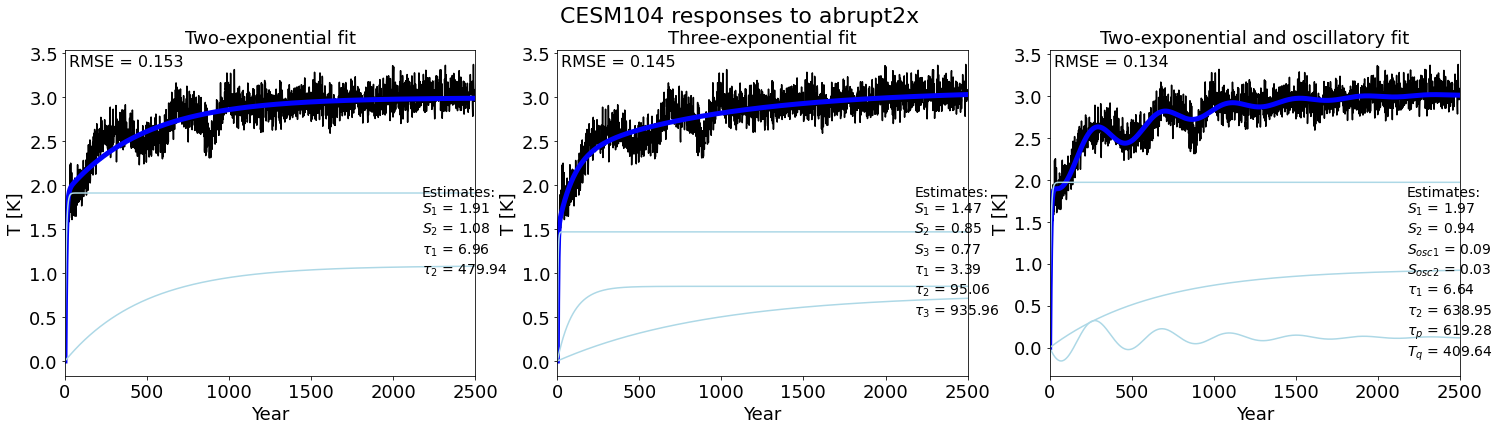

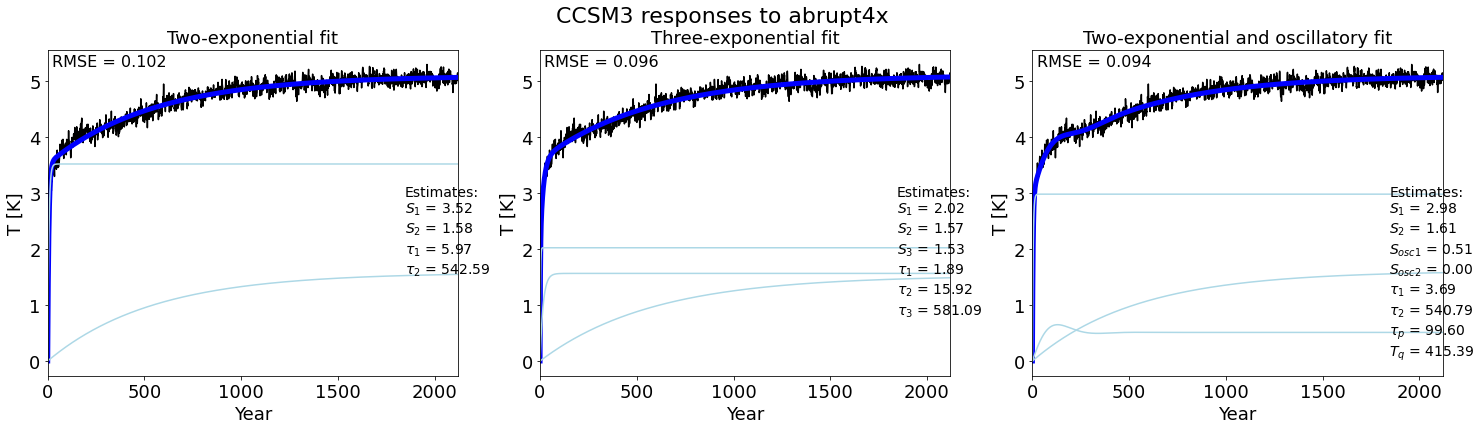

In [23]:
rmse_list = []
for model in ['CESM104', 'CCSM3']:
#for model in all_abruptexp:
    if model == 'CESM104':
        exp = 'abrupt2x'
    elif model == 'CCSM3':
        exp = 'abrupt4x'
        
    [years0, deltaT0] = get_tas(model, exp, add_0 = True, remove_nan = True, return_years = True)
    #rmse_values = plot_3fits(years0, deltaT0, model, exp)
    #rmse_values = plot_3fits(years0, deltaT0, model, exp, load_results = False, save_results = True, save_figure = True)
    rmse_values = plot_3fits_longrunmip(years0, deltaT0, model, exp, load_results = True, save_results = False, save_figure = False)
    rmse_values = [model, exp] + rmse_values
    rmse_list.append(rmse_values)
    plt.show()

CESM104
[0.1526133918603012, 0.1453573875043357, 0.13445759450383601]
CCSM3
[0.1015011441232921, 0.0963432444392737, 0.09432344417194424]


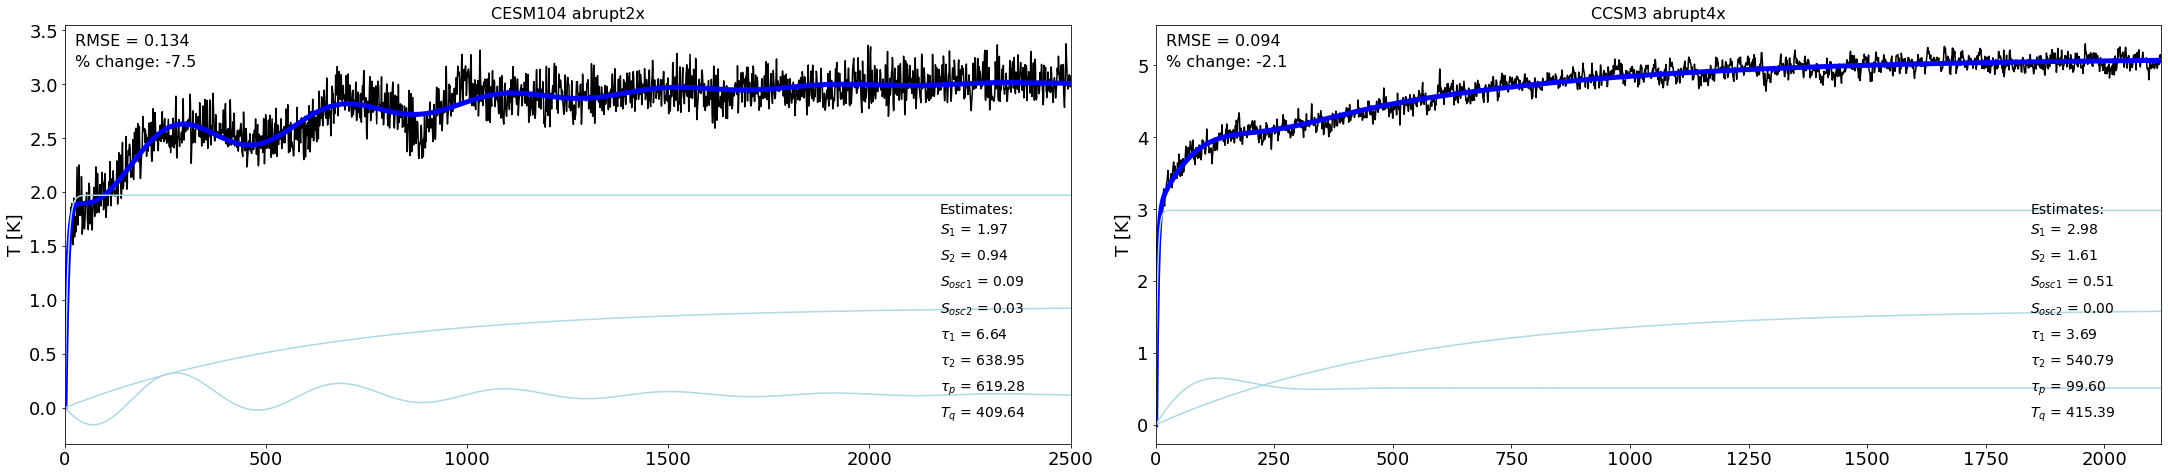

In [24]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = [30,26/4], constrained_layout=True)
#ax = np.concatenate(axes)
#plt.tight_layout()
#plt.subplots_adjust(hspace=0.01)
k = 0 # axis index
for model in ['CESM104', 'CCSM3']:
#for model in member_dict:
    print(model)
    if model == 'CESM104':
        exp = 'abrupt2x'
        rmse_values = rmse_list[0][2:]
    elif model == 'CCSM3':
        exp = 'abrupt4x'
        rmse_values = rmse_list[1][2:]
    print(rmse_values)   
    [years0, deltaT0] = get_tas(model, exp, add_0 = True, remove_nan = True, return_years = True)
    result_file = '../model_results_longrunmip/' + model + '_' + exp + '_expandosc_results.sav'
    model_result = load_modelresult(result_file, funcdefs = {'expandosc_function': expandosc_function})
    ax[k] = modelresult_figure_longrunmip('expandosc', model_result, years0, deltaT0, axis = ax[k])
    ax[k].set_title(model + ' ' + exp, fontsize = 16)
    #ax[k].set_title(model + ' ' + exp + ' ' + member, fontsize = 16)
    rmse_change = 100*(rmse_values[2] - rmse_values[1])/rmse_values[1]
    ax[k].text(0.01, 0.9, '% change: ' + str(np.round(rmse_change,1)), transform=ax[k].transAxes, fontsize = 16)
    if k<12:
        ax[k].set_xlabel('')
    k += 1
        

#plt.savefig('../Figures/longrunmip_2expandosc_results.png', format='png', dpi=600, bbox_inches="tight")        
#plt.savefig('../Figures/longrunmip_2expandosc_results.pdf', format='pdf', dpi=600, bbox_inches="tight")        


## Combined figure

In [25]:
fig.subfigures?

Signature:
fig.subfigures(
    nrows=1,
    ncols=1,
    squeeze=True,
    wspace=None,
    hspace=None,
    width_ratios=None,
    height_ratios=None,
    **kwargs,
)
Docstring:
Add a subfigure to this figure or subfigure.

A subfigure has the same artist methods as a figure, and is logically
the same as a figure, but cannot print itself.
See :doc:`/gallery/subplots_axes_and_figures/subfigures`.

Parameters
----------
nrows, ncols : int, default: 1
    Number of rows/columns of the subfigure grid.

squeeze : bool, default: True
    If True, extra dimensions are squeezed out from the returned
    array of subfigures.

wspace, hspace : float, default: None
    The amount of width/height reserved for space between subfigures,
    expressed as a fraction of the average subfigure width/height.
    If not given, the values will be inferred from a figure or
    rcParams when necessary.

width_ratios : array-like of length *ncols*, optional
    Defines the relative widths of the columns. Each

In [9]:
exp

'abrupt4x'

In [31]:
subfigs[0].subplots?

Object `subplots` not found.


In [ ]:
subfigs[0].subplots

ACCESS-CM2
GISS-E2-1-G
ICON-ESM-LR
KIOST-ESM
MRI-ESM2-0
NorESM2-LM
SAM0-UNICON
TaiESM1
CESM104
CCSM3


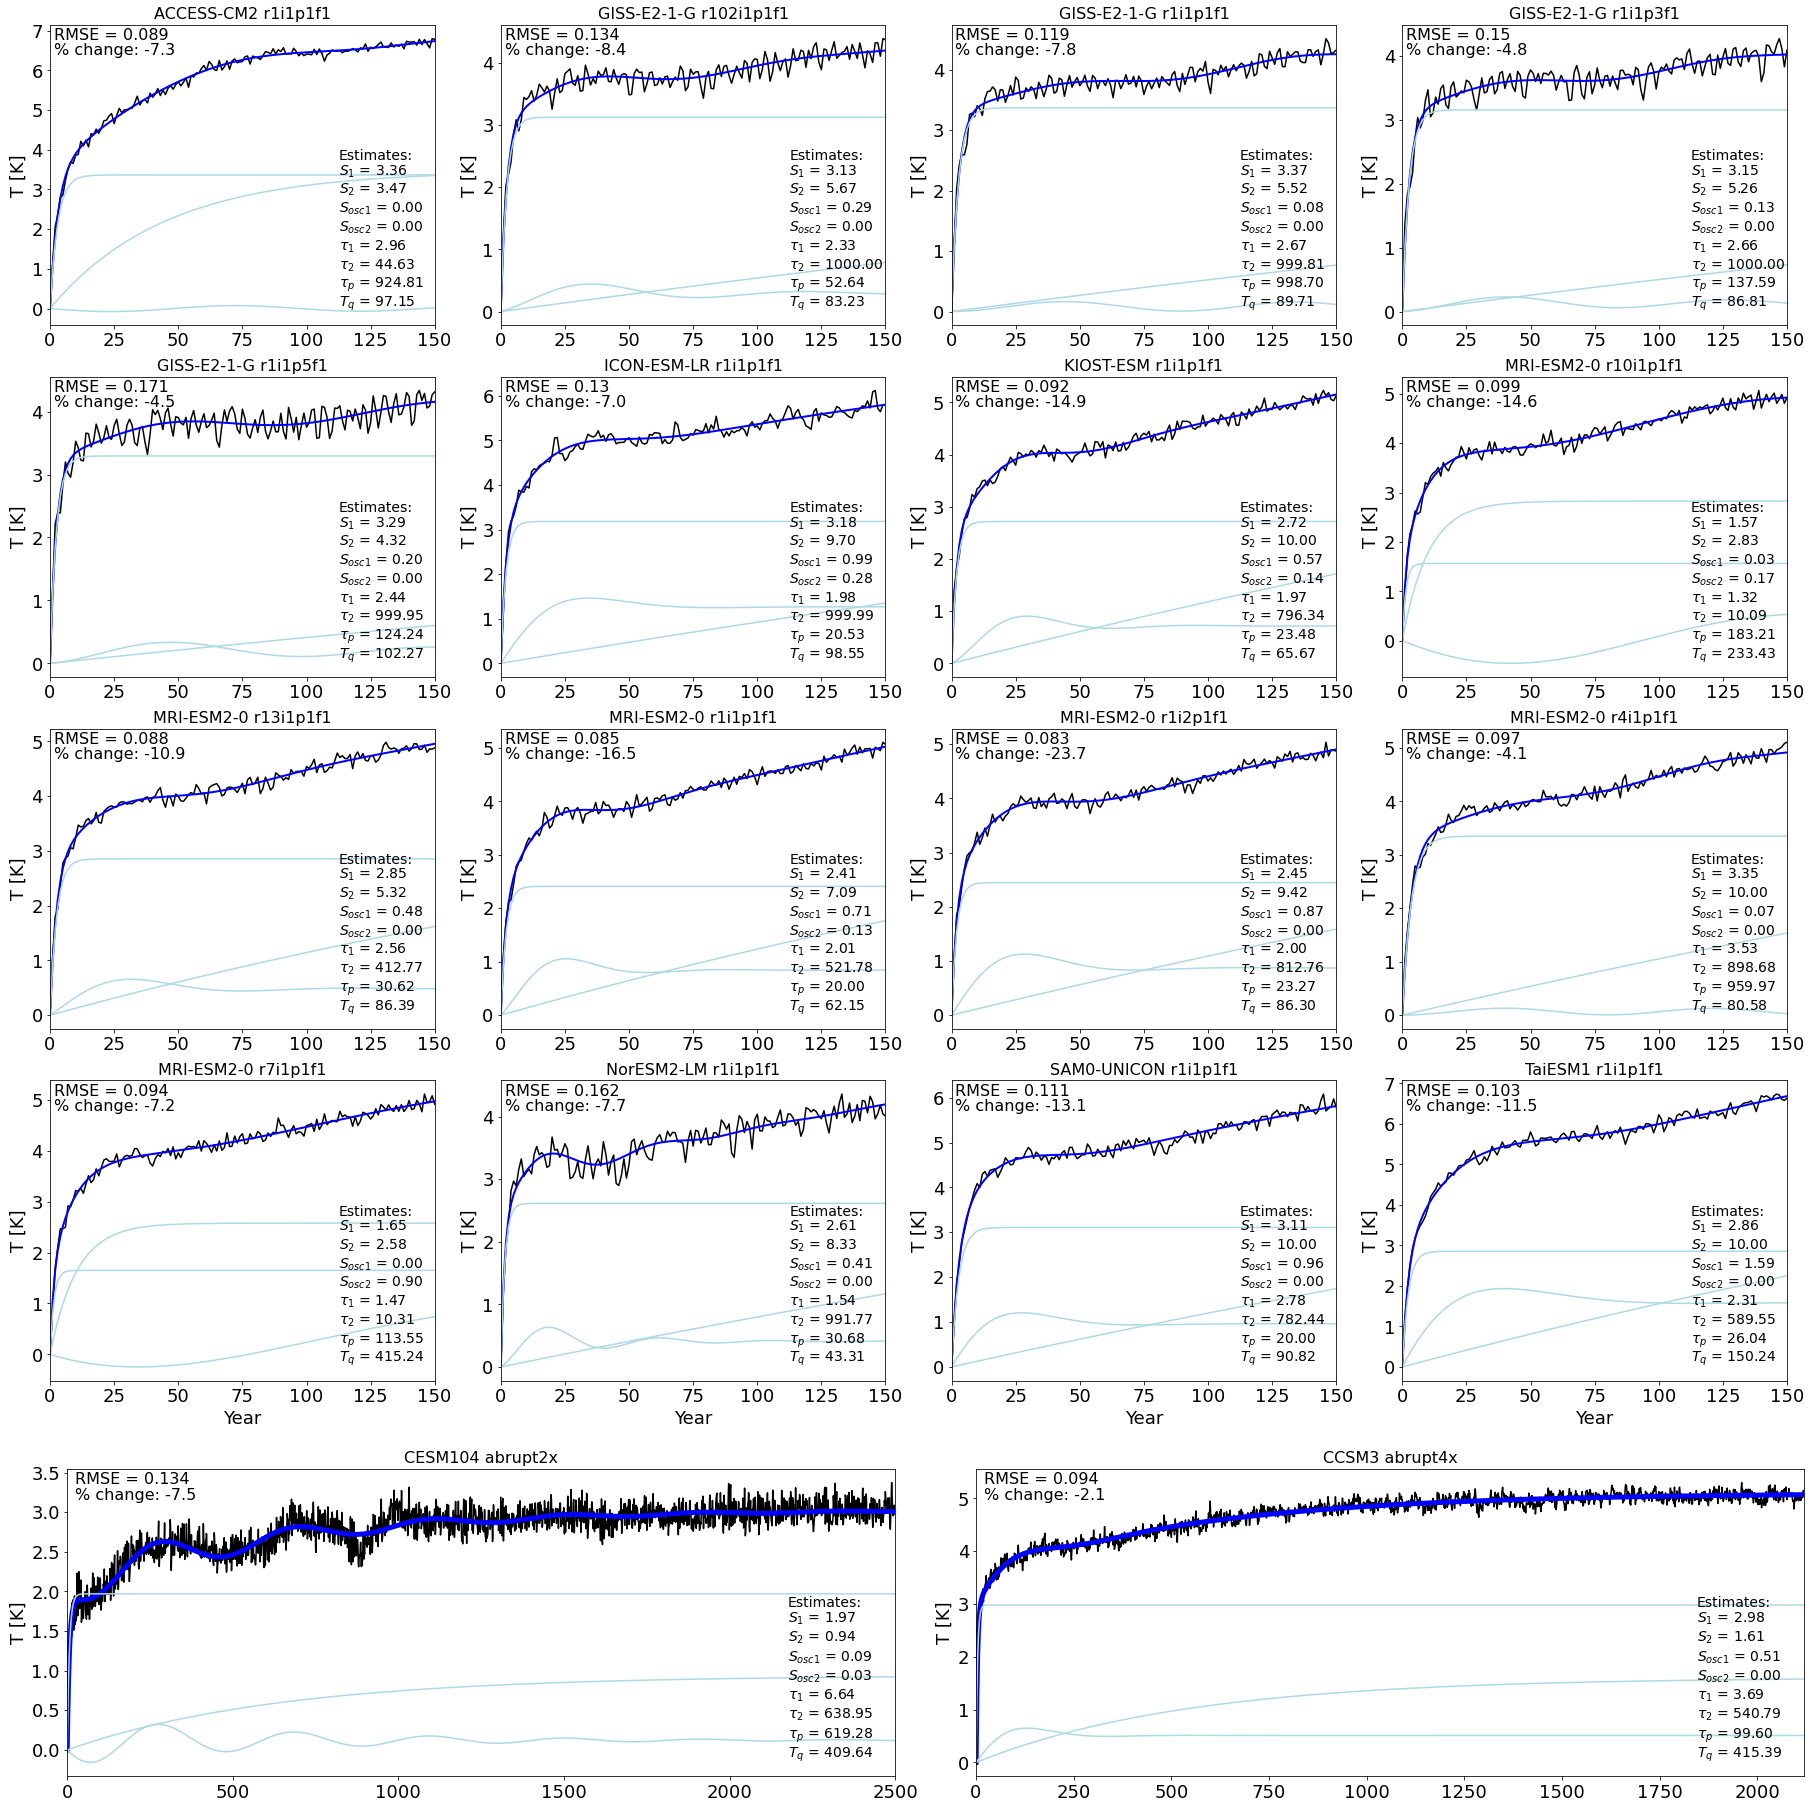

In [35]:
exp = 'abrupt-4xCO2'

fig = plt.figure(figsize = [25,25], constrained_layout=True)
subfigs = fig.subfigures(2, 1, height_ratios = [4,1])
upper_axes = subfigs[0].subplots(nrows = 4, ncols = 4)
lower_axes = subfigs[1].subplots(nrows = 1, ncols = 2)

# upper axes:
ax = np.concatenate(upper_axes)
k = 0 # axis index
for model in ['ACCESS-CM2', 'GISS-E2-1-G', 'ICON-ESM-LR', 'KIOST-ESM', 'MRI-ESM2-0', 'NorESM2-LM', 'SAM0-UNICON', 'TaiESM1']:
#for model in member_dict:
    print(model)
    for member in member_dict[model]:
        data = load_anom(model, exp, member, length_restriction = 150)
        deltaN = data['rsdt'] - data['rsut'] - data['rlut']
        deltaT = data['tas']; years = np.arange(1,150+1)
        if len(deltaT)<150:
            continue
        deltaT0 = np.concatenate(([0],deltaT)); years0 = np.concatenate(([0],years))
        result_file = '../model_results/' + model + '_' + exp + '_' + member + '_expandosc_results.sav'
        model_result = load_modelresult(result_file, funcdefs = {'expandosc_function': expandosc_function})
        ax[k] = modelresult_figure('expandosc', model_result, years0, deltaT0, axis = ax[k])
        ax[k].set_title(model + ' ' + member, fontsize = 16)
        #ax[k].set_title(model + ' ' + exp + ' ' + member, fontsize = 16)
        rmse_change = 100*(rmse_dict[model][member][2] - rmse_dict[model][member][1])/rmse_dict[model][member][1]
        ax[k].text(0.01, 0.9, '% change: ' + str(np.round(rmse_change,1)), transform=ax[k].transAxes, fontsize = 16)
        if k<12:
            ax[k].set_xlabel('')
        k += 1
        
# lower axes:
ax = lower_axes
k = 0 # axis index
for model in ['CESM104', 'CCSM3']:
    print(model)
    if model == 'CESM104':
        exp = 'abrupt2x'
        rmse_values = rmse_list[0][2:]
    elif model == 'CCSM3':
        exp = 'abrupt4x'
        rmse_values = rmse_list[1][2:]
    #print(rmse_values)   
    [years0, deltaT0] = get_tas(model, exp, add_0 = True, remove_nan = True, return_years = True)
    result_file = '../model_results_longrunmip/' + model + '_' + exp + '_expandosc_results.sav'
    model_result = load_modelresult(result_file, funcdefs = {'expandosc_function': expandosc_function})
    ax[k] = modelresult_figure_longrunmip('expandosc', model_result, years0, deltaT0, axis = ax[k])
    ax[k].set_title(model + ' ' + exp, fontsize = 16)
    rmse_change = 100*(rmse_values[2] - rmse_values[1])/rmse_values[1]
    ax[k].text(0.01, 0.9, '% change: ' + str(np.round(rmse_change,1)), transform=ax[k].transAxes, fontsize = 16)
    if k<12:
        ax[k].set_xlabel('')
    k += 1
        
        

#plt.savefig('../Figures/18_combined_expandosc_results.pdf', format='pdf', dpi=600, bbox_inches="tight")                

